# Videogame Platform Prediction

Dataset definition:	Video game sales data from more than 16,500 games. (2016) <br>
Dataset source: https://www.kaggle.com/datasets/gregorut/videogamesales <br>
Our goal:	Predict the platform of the game using classification models.

In [65]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score
from sklearn.feature_selection import VarianceThreshold, SelectKBest, chi2, RFE, SelectFromModel
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from matplotlib.lines import Line2D

In [66]:
# Import dataset and show the overview of the dataframe.
# NA_Sales + EU_Sales + JP_Sales + Other_sales = Global_Sales
df = pd.read_csv("vgsales.csv", index_col="Rank")
df

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
Rank,,,,,,,,,,
1,Wii Sports,Wii,2006.0,Sports,Nintendo,41.49,29.02,3.77,8.46,82.74
2,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24
3,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.85,12.88,3.79,3.31,35.82
4,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.75,11.01,3.28,2.96,33.00
5,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37
...,...,...,...,...,...,...,...,...,...,...
16596,Woody Woodpecker in Crazy Castle 5,GBA,2002.0,Platform,Kemco,0.01,0.00,0.00,0.00,0.01
16597,Men in Black II: Alien Escape,GC,2003.0,Shooter,Infogrames,0.01,0.00,0.00,0.00,0.01
16598,SCORE International Baja 1000: The Official Game,PS2,2008.0,Racing,Activision,0.00,0.00,0.00,0.00,0.01


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16598 entries, 1 to 16600
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Name          16598 non-null  object 
 1   Platform      16598 non-null  object 
 2   Year          16327 non-null  float64
 3   Genre         16598 non-null  object 
 4   Publisher     16540 non-null  object 
 5   NA_Sales      16598 non-null  float64
 6   EU_Sales      16598 non-null  float64
 7   JP_Sales      16598 non-null  float64
 8   Other_Sales   16598 non-null  float64
 9   Global_Sales  16598 non-null  float64
dtypes: float64(6), object(4)
memory usage: 1.4+ MB


In [3]:
# There are 31 classes which we will try to predict.
df.Platform.nunique()

31

In [4]:
df.Platform.unique()

array(['Wii', 'NES', 'GB', 'DS', 'X360', 'PS3', 'PS2', 'SNES', 'GBA',
       '3DS', 'PS4', 'N64', 'PS', 'XB', 'PC', '2600', 'PSP', 'XOne', 'GC',
       'WiiU', 'GEN', 'DC', 'PSV', 'SAT', 'SCD', 'WS', 'NG', 'TG16',
       '3DO', 'GG', 'PCFX'], dtype=object)

In [5]:
# There are 271 rows without a Year value and 58 rows without a Publisher value.
df.isna().sum()

Name              0
Platform          0
Year            271
Genre             0
Publisher        58
NA_Sales          0
EU_Sales          0
JP_Sales          0
Other_Sales       0
Global_Sales      0
dtype: int64

In [6]:
# There is only one duplicated entry
df.duplicated().sum()

1

In [7]:
# There is a very strong correlation between NA/EU sales and global sales.
# There is a strong correlation between NA sales and EU sales.
# There is a moderate correlation between JP sales and NA/EU/global sales.
df.corr()

,Year,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
Year,1.000000,-0.091402,0.006014,-0.169316,0.041058,-0.074735
NA_Sales,-0.091402,1.000000,0.767727,0.449787,0.634737,0.941047
EU_Sales,0.006014,0.767727,1.000000,0.435584,0.726385,0.902836
JP_Sales,-0.169316,0.449787,0.435584,1.000000,0.290186,0.611816
Other_Sales,0.041058,0.634737,0.726385,0.290186,1.000000,0.748331
Global_Sales,-0.074735,0.941047,0.902836,0.611816,0.748331,1.000000


In [8]:
# There are 16598 rows of data and each of them has 10 columns of attributes.
df.shape

(16598, 10)

In [9]:
# Name: The name of the game (string)
# Platform: The main gaming platform of the game (string)
# Year: The year in which the game was released (number)
# Genre: The most significant genre of the game (string)
# Publisher: The company that released the game (string)
# NA_Sales: Sales in North America (number)
# EU_Sales: Sales in Europe (number)
# JP_Sales: Sales in Japan (number)
# Other_Sales: Sales elsewhere (number)
# Global_Sales: Total number of sales (number)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16598 entries, 1 to 16600
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Name          16598 non-null  object 
 1   Platform      16598 non-null  object 
 2   Year          16327 non-null  float64
 3   Genre         16598 non-null  object 
 4   Publisher     16540 non-null  object 
 5   NA_Sales      16598 non-null  float64
 6   EU_Sales      16598 non-null  float64
 7   JP_Sales      16598 non-null  float64
 8   Other_Sales   16598 non-null  float64
 9   Global_Sales  16598 non-null  float64
dtypes: float64(6), object(4)
memory usage: 1.4+ MB


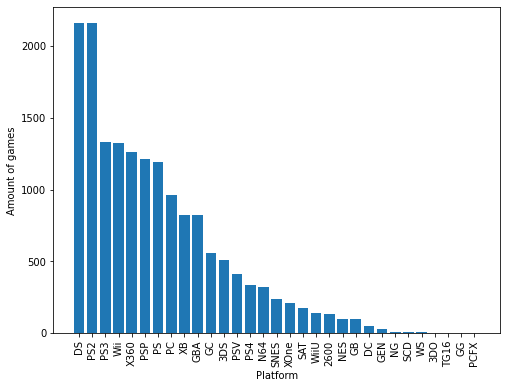

In [68]:
# Set the size of the plot.
fig = plt.figure(figsize=[8,6])
ax = fig.add_subplot(111)

# We will see how many games each platform has.
# We make the labels thicker and rotate them vertically, so the label texts don't overlap.
# In the barplot below, we can see that most games are from the DS and PS2 platform.
x = df.Platform.value_counts().index
y = df.Platform.value_counts().values
plt.setp(ax.get_xticklabels(), fontsize=10, rotation='vertical')
plt.bar(x,y)
plt.xlabel('Platform')
plt.ylabel('Amount of games')
plt.show()

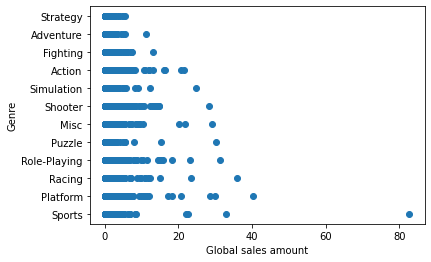

In [69]:
# Below we can see the relationship between global sales and genres.
# The more dots to the right, the more games with very high sales.
# The most sold game is from the sports genre.
# The strategy genre does not have a game that stands out from the other games of the same genre.
# Most of the genres have at least one game that stands out a lot from the other games of the respective genre.
plt.scatter(df.Global_Sales.values,df.Genre.values)
plt.xlabel('Global sales amount')
plt.ylabel('Genre')
plt.show()

In [12]:
# The Year column has 271 missing values.
# The Publisher column has 58 missing values.
df.isna().sum()

Name              0
Platform          0
Year            271
Genre             0
Publisher        58
NA_Sales          0
EU_Sales          0
JP_Sales          0
Other_Sales       0
Global_Sales      0
dtype: int64

In [51]:
df.isna().sum()

Name              0
Platform          0
Year            271
Genre             0
Publisher        58
NA_Sales          0
EU_Sales          0
JP_Sales          0
Other_Sales       0
Global_Sales      0
dtype: int64

In [15]:
# The release year of a game can not be filled as it could be any value.
# The publisher of a game could also be of any value.
# Therefore I will delete the rows which have any of the both missing.
# 307 rows will be deleted.
df = df.dropna()
df

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
Rank,,,,,,,,,,
1,Wii Sports,Wii,2006.0,Sports,Nintendo,41.49,29.02,3.77,8.46,82.74
2,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24
3,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.85,12.88,3.79,3.31,35.82
4,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.75,11.01,3.28,2.96,33.00
5,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37
...,...,...,...,...,...,...,...,...,...,...
16596,Woody Woodpecker in Crazy Castle 5,GBA,2002.0,Platform,Kemco,0.01,0.00,0.00,0.00,0.01
16597,Men in Black II: Alien Escape,GC,2003.0,Shooter,Infogrames,0.01,0.00,0.00,0.00,0.01
16598,SCORE International Baja 1000: The Official Game,PS2,2008.0,Racing,Activision,0.00,0.00,0.00,0.00,0.01


In [14]:
# No missing values remaining.
df.isna().sum()

Name            0
Platform        0
Year            0
Genre           0
Publisher       0
NA_Sales        0
EU_Sales        0
JP_Sales        0
Other_Sales     0
Global_Sales    0
dtype: int64

In [15]:
# There is no need for transformation in my opinion.
# The numerical columns are all straightforward, we can't extract new features out of them.
# The strings are also self-sufficient.
df

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
Rank,,,,,,,,,,
1,Wii Sports,Wii,2006.0,Sports,Nintendo,41.49,29.02,3.77,8.46,82.74
2,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24
3,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.85,12.88,3.79,3.31,35.82
4,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.75,11.01,3.28,2.96,33.00
5,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37
...,...,...,...,...,...,...,...,...,...,...
16596,Woody Woodpecker in Crazy Castle 5,GBA,2002.0,Platform,Kemco,0.01,0.00,0.00,0.00,0.01
16597,Men in Black II: Alien Escape,GC,2003.0,Shooter,Infogrames,0.01,0.00,0.00,0.00,0.01
16598,SCORE International Baja 1000: The Official Game,PS2,2008.0,Racing,Activision,0.00,0.00,0.00,0.00,0.01


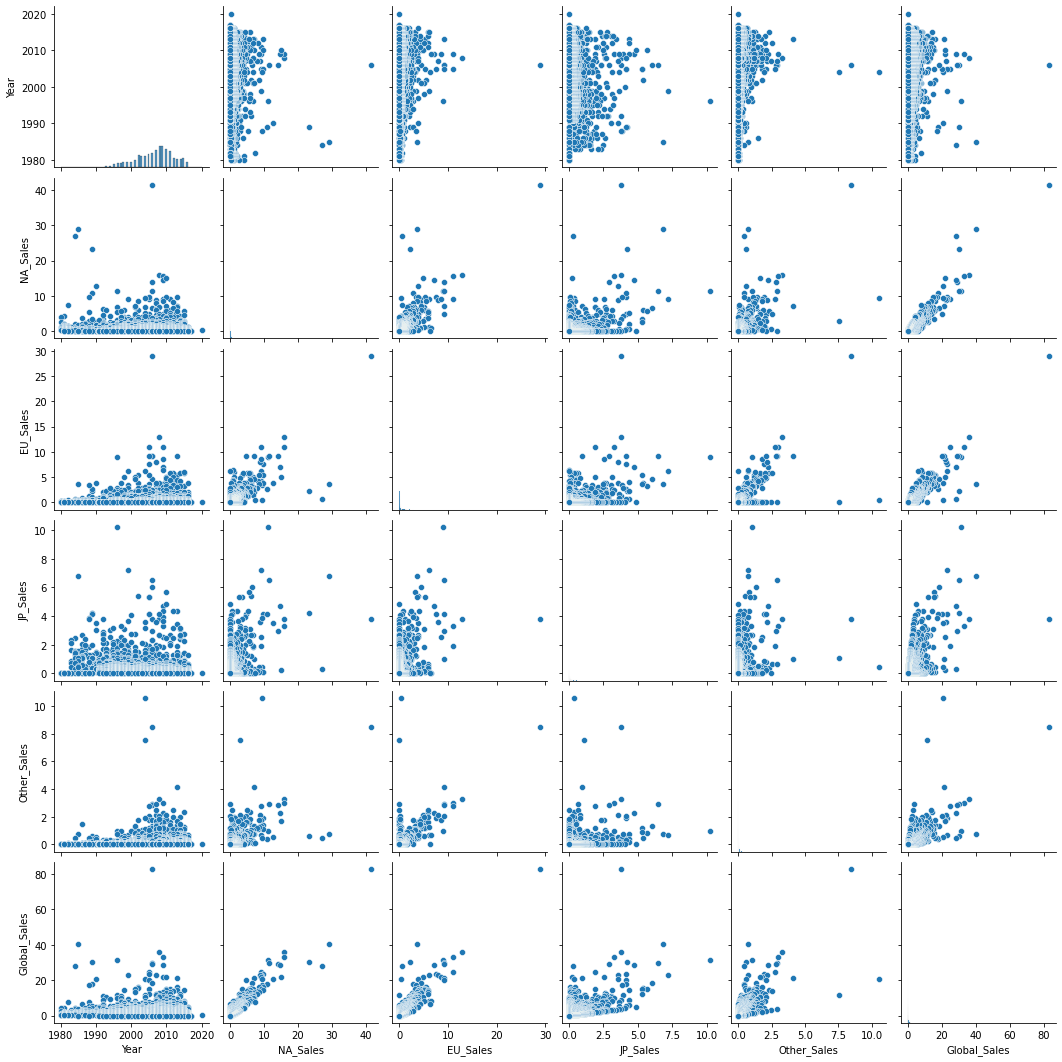

In [17]:
# Below we can see the pairplot of all numerical features.
# I don't think the results help us much in finding valuable features, therefore I will try different graphs.
sns.pairplot(df)

<AxesSubplot:xlabel='Year', ylabel='Platform'>

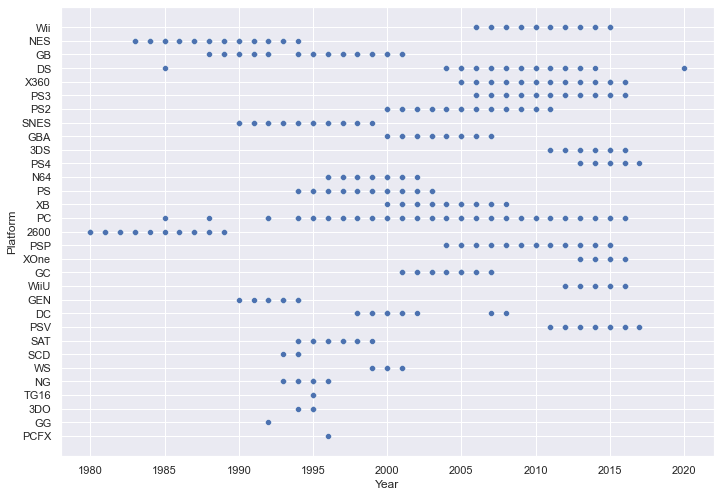

In [54]:
# We can clearly see patterns in the scatter plot below.
# Every platform seems to release it's games over a certain year range.
# Therefore 'Year' will be a useful feature for our task.
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.scatterplot(data=df, x='Year', y='Platform')

<AxesSubplot:xlabel='Genre', ylabel='Platform'>

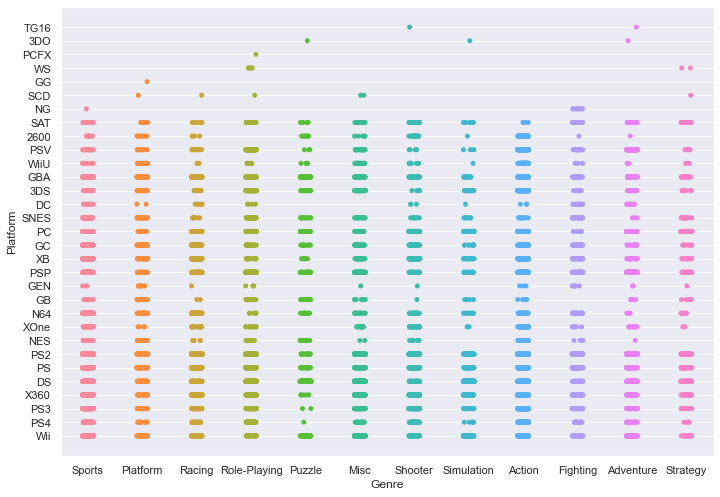

In [55]:
# Obviously every game genre will be present in every game platform, therefore 'Genre' is not an useful feature.
sns.stripplot(data=df, x='Genre', y='Platform')

In [16]:
# It might be better to use the sales ratio of each region instead of simply their raw sales numbers.
# For example, instead of knowing the raw total sales in JP, we should rather know how much % of
# total global sales are from JP.
# The global sales column however can stay at it is.
def set_sales_ratio(df):
    df = df.assign(NA_Sales = lambda x: x.NA_Sales / x.Global_Sales)
    df = df.assign(EU_Sales = lambda x: x.EU_Sales / x.Global_Sales)
    df = df.assign(JP_Sales = lambda x: x.JP_Sales / x.Global_Sales)
    df = df.assign(Other_Sales = lambda x: x.Other_Sales / x.Global_Sales)
    return df
    
df = set_sales_ratio(df)
df

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
Rank,,,,,,,,,,
1,Wii Sports,Wii,2006.0,Sports,Nintendo,0.501450,0.350737,0.045564,0.102248,82.74
2,Super Mario Bros.,NES,1985.0,Platform,Nintendo,0.722664,0.088966,0.169235,0.019135,40.24
3,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,0.442490,0.359576,0.105807,0.092406,35.82
4,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,0.477273,0.333636,0.099394,0.089697,33.00
5,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,0.359260,0.283392,0.325789,0.031878,31.37
...,...,...,...,...,...,...,...,...,...,...
16596,Woody Woodpecker in Crazy Castle 5,GBA,2002.0,Platform,Kemco,1.000000,0.000000,0.000000,0.000000,0.01
16597,Men in Black II: Alien Escape,GC,2003.0,Shooter,Infogrames,1.000000,0.000000,0.000000,0.000000,0.01
16598,SCORE International Baja 1000: The Official Game,PS2,2008.0,Racing,Activision,0.000000,0.000000,0.000000,0.000000,0.01


In [17]:
# Drop platforms that have less than 10 data.
# We will perform cross-validation later on, therefore a class with too little data
# will throw us an error. We need a certain amount of data of each class in order to
# perform cross-validation.
def drop_small_platforms(df):
    df = df.groupby('Platform').filter(lambda x : len(x) >= 10)
    return df

df = drop_small_platforms(df)
len(df)

16272

In [18]:
# X is the data, y are the target labels.
def get_X_y(df):
    X = df.loc[:, 'Year':'Global_Sales']
    y = df.loc[:, 'Platform']
    return X,y

X,y = get_X_y(df)
X

,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
Rank,,,,,,,,
1,2006.0,Sports,Nintendo,0.501450,0.350737,0.045564,0.102248,82.74
2,1985.0,Platform,Nintendo,0.722664,0.088966,0.169235,0.019135,40.24
3,2008.0,Racing,Nintendo,0.442490,0.359576,0.105807,0.092406,35.82
4,2009.0,Sports,Nintendo,0.477273,0.333636,0.099394,0.089697,33.00
5,1996.0,Role-Playing,Nintendo,0.359260,0.283392,0.325789,0.031878,31.37
...,...,...,...,...,...,...,...,...
16596,2002.0,Platform,Kemco,1.000000,0.000000,0.000000,0.000000,0.01
16597,2003.0,Shooter,Infogrames,1.000000,0.000000,0.000000,0.000000,0.01
16598,2008.0,Racing,Activision,0.000000,0.000000,0.000000,0.000000,0.01


In [19]:
# Turn string data into numeric data using a label encoder.
def encode_labels(X,y):
    le = LabelEncoder()
    y = le.fit_transform(y)
    X.Genre = le.fit_transform(X.Genre)
    X.Publisher = le.fit_transform(X.Publisher)
    return X,y

X,y = encode_labels(X,y)
X

,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
Rank,,,,,,,,
1,2006.0,10,358,0.501450,0.350737,0.045564,0.102248,82.74
2,1985.0,4,358,0.722664,0.088966,0.169235,0.019135,40.24
3,2008.0,6,358,0.442490,0.359576,0.105807,0.092406,35.82
4,2009.0,10,358,0.477273,0.333636,0.099394,0.089697,33.00
5,1996.0,7,358,0.359260,0.283392,0.325789,0.031878,31.37
...,...,...,...,...,...,...,...,...
16596,2002.0,4,268,1.000000,0.000000,0.000000,0.000000,0.01
16597,2003.0,8,240,1.000000,0.000000,0.000000,0.000000,0.01
16598,2008.0,6,21,0.000000,0.000000,0.000000,0.000000,0.01


In [20]:
# Split the dataset into train and test data.
# Stratify, so that both train and test has an equal rate of data for each class.
# Our next step will be to scale the features, this is why we have to split the
# data now, as we don't want data leakage to happen between train and test sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)

In [21]:
# Scale integer data into floating points that start from 0 and go to 1.
# This way our model will converge faster and also give us better accuracies.
# It is generally recommended to scale numbers like this in machine learning tasks.
# The reason we use min-max scaling and not standard scaling (mean=0, std=1) is
# that the naive bayes model doesn't accept minus numbers.
def scale(X_train, X_test):
    scaler = MinMaxScaler()
    col_sc = ['Genre','Publisher','Year','Global_Sales']
    for col in col_sc:
        X_train[col] = scaler.fit_transform(X_train[col].to_numpy().reshape(-1, 1))
        X_test[col] = scaler.transform(X_test[col].to_numpy().reshape(-1, 1))
    return X_train, X_test

X_train, X_test = scale(X_train, X_test)
X_train

,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
Rank,,,,,,,,
4499,0.525,0.909091,0.240418,0.953488,0.046512,0.000000,0.000000,0.005077
687,0.600,0.727273,0.240418,0.367965,0.458874,0.038961,0.138528,0.027801
4582,0.725,0.272727,0.036585,0.547619,0.357143,0.000000,0.095238,0.004956
8961,0.700,0.363636,0.010453,0.000000,0.000000,1.000000,0.000000,0.001692
6022,0.800,0.000000,0.240418,0.206897,0.689655,0.000000,0.103448,0.003385
...,...,...,...,...,...,...,...,...
303,0.625,0.272727,0.602787,0.522613,0.339196,0.000000,0.135678,0.047987
7716,0.550,0.636364,0.939024,0.750000,0.200000,0.000000,0.050000,0.002297
5935,0.625,0.818182,0.522648,1.000000,0.000000,0.000000,0.000000,0.003505


In [22]:
# After performing feature engineering, we reshape our data back into processable form.
def reshape_data(X_train,X_test,y_train,y_test):
    col_rs = ['Genre','Publisher','Year','Global_Sales']
    for col in col_rs:
        X_train[col] = X_train[col].to_numpy().reshape(1,-1)[0]
        X_test[col] = X_test[col].to_numpy().reshape(1,-1)[0]
    y_train = y_train.reshape(1,-1)[0]
    y_test = y_test.reshape(1,-1)[0]
    return X_train,X_test,y_train,y_test

X_train,X_test,y_train,y_test = reshape_data(X_train,X_test,y_train,y_test)
X_train

,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
Rank,,,,,,,,
4499,0.525,0.909091,0.240418,0.953488,0.046512,0.000000,0.000000,0.005077
687,0.600,0.727273,0.240418,0.367965,0.458874,0.038961,0.138528,0.027801
4582,0.725,0.272727,0.036585,0.547619,0.357143,0.000000,0.095238,0.004956
8961,0.700,0.363636,0.010453,0.000000,0.000000,1.000000,0.000000,0.001692
6022,0.800,0.000000,0.240418,0.206897,0.689655,0.000000,0.103448,0.003385
...,...,...,...,...,...,...,...,...
303,0.625,0.272727,0.602787,0.522613,0.339196,0.000000,0.135678,0.047987
7716,0.550,0.636364,0.939024,0.750000,0.200000,0.000000,0.050000,0.002297
5935,0.625,0.818182,0.522648,1.000000,0.000000,0.000000,0.000000,0.003505


By using the percentages of regional sales instead of raw numbers, we might infer the platform of the game, because some platforms might be more popular in different regions, therefore those features could be more useful for us. I left the global sales as it is, because the total global sales number will be important in knowing how popular and successful the game was. Platforms that sold less will most likely have lower game sales too.

I will mainly use accuracy and F1-score as my main performance evaluation techniques.<br>
<ol>
<li>Accuracy is the most used metric in machine learning. It is simply the ratio of accurate predictions. Both true positives and true negatives should be maximised.<br>
(Accuracy = TP + TN / TP + TN + FP + FN)</li>
<li>F1-score is another metric used in machine learning. It is the harmonic average of precision and recall, which are yet other types of machine learning metrics. Precision is when we want to maximise the amount of true positives, and recall is when we want to decrease the amount of missed positives.<br>
(F1-score = 2TP / 2TP + FP + FN)</li>
</ol>

<AxesSubplot:xlabel='Year', ylabel='Global_Sales'>

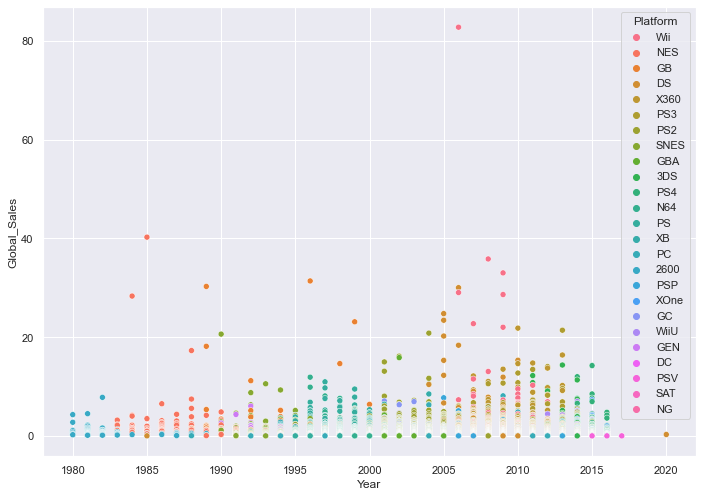

In [18]:
# In the below graph we are trying to infer if there is class tendency by using
# Year and Global_Sales properties. While little clusters with same colors are
# visible, it is not enough to help us for the classification task.
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.scatterplot(data=df, x='Year', y='Global_Sales', hue='Platform')

I will use logistic regression and naïve bayes classifier as my classification models.

<ol>
<li>Naive bayes is a probabilistic model that assumes conditional independence between the features. It utilizes Bayes' theorem in it's calculations.<br>
The parameter I will test is 'alpha'. It specifies how much additive smoothing should happen.</li>
<li>Logistic regression is a classification model that is used for binary classification, but it can also be used for multiclass classification. It uses the sigmoid function and a threshold value in order to perform classification.<br>
The parameter that I am going to tune is 'C'. C is the inverse regularization strength. The lower it is, the stronger the regularization will be.</li>
</ol>

In [23]:
# The grid search cross-validation parameters.
# We define which models we are going to use, plus their respective hyper-parameters.
models = [
    {
        'clf': MultinomialNB(),
        'parameters': {
            'alpha': [1.0, 0.1, 0.01, 0.001, 0.0001]
        }
    },
    {
        'clf': LogisticRegression(random_state=0, solver='saga', max_iter=2000),
        'parameters': {
            'C': [1, 5, 10, 20, 50]
        }
    }
]

In [24]:
# Finally, for each classification model, we will try out all parameters.
# The grid search cross-validation will tell us the best parameters of each model.
for model in models:
    grid_cv = GridSearchCV(model['clf'], model['parameters'], scoring='accuracy')
    grid_cv.fit(X_train, y_train)
    y_pred = grid_cv.predict(X_test)
    print("Model: " + model['clf'].__class__.__name__)
    print("Best accuracy: " + str(grid_cv.best_score_))
    print("Best parameters: " + str(grid_cv.best_params_))
    print("F1 score: " + str(f1_score(y_test, y_pred, average='micro')))

Model: MultinomialNB
Best accuracy: 0.22713836710297447
Best parameters: {'alpha': 1.0}
F1 score: 0.22713864306784662
Model: LogisticRegression
Best accuracy: 0.4841034311388103
Best parameters: {'C': 50}
F1 score: 0.48303834808259594


As we can see from above results, multinomial naive bayes' best parameter is alpha=1.0, and the best accuracy it got is 0.22. The micro f1-score is 0.22 as well.<br>
Meanwhile, logistic regression's best parameter is C=50 with an accuracy of 0.484. The micro f1-score is 0.483.

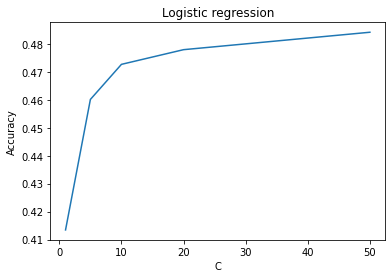

In [25]:
# Plot the effect of the C parameter on the mean_test_score of the cross-validation.
plt.plot(grid_cv.param_grid['C'], grid_cv.cv_results_['mean_test_score'])
plt.title('Logistic regression')
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.show()

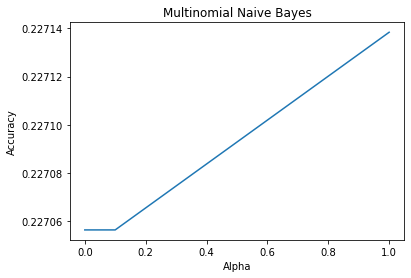

In [27]:
# Train naive bayes again, as the previous grid_cv variable stores logit information.
mnb = models[0]
grid_cv_mnb = GridSearchCV(mnb['clf'], mnb['parameters'], scoring='accuracy')
grid_cv_mnb.fit(X_train, y_train)

# Plot the effect of the alpha parameter on the mean_test_score of the cross-validation.
plt.plot(grid_cv_mnb.param_grid['alpha'], grid_cv_mnb.cv_results_['mean_test_score'])
plt.title('Multinomial Naive Bayes')
plt.xlabel('Alpha')
plt.ylabel('Accuracy')
plt.show()

Logistic regression performs way better than multinomial naive bayes. It increased the accuracy from 0.22 to 0.484, thus increasing it by 0.264. This is a big increase, which means that multinomial naive bayes' assumption of conditional independence between features has hurt the accuracy score a lot. This means that our features are not conditionally independent and therefore conditional dependence between our features should be assumed, and therefore the multinomial naive bayes model should be avoided.

In [28]:
# We will use a 99.7% confidence interval and remove the values that reside outside
# of this interval. First, calculate the first and third quarter, then calculate the
# interquartile range of each feature.
Q1 = X.quantile(0.03)
Q3 = X.quantile(0.97)
IQR = Q3 - Q1
IQR

Year             20.000000
Genre            11.000000
Publisher       525.000000
NA_Sales          1.000000
EU_Sales          0.921019
JP_Sales          1.000000
Other_Sales       0.222192
Global_Sales      2.898700
dtype: float64

In [30]:
# If the values of an entry is beyond our confidence interval, we will remove it.
condition = ~((X < (Q1 - 1.5 * IQR)) | (X > (Q3 + 1.5 * IQR))).any(axis=1)
filtered_df = df[condition]
filtered_df

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
Rank,,,,,,,,,,
104,Battlefield 3,PS3,2011.0,Shooter,Electronic Arts,0.394191,0.405256,0.048409,0.152144,7.23
105,Need for Speed Underground,PS2,2003.0,Racing,Electronic Arts,0.454167,0.393056,0.011111,0.141667,7.20
106,Tekken 3,PS,1998.0,Fighting,Sony Computer Entertainment,0.456704,0.310056,0.195531,0.040503,7.16
107,Crash Bandicoot 3: Warped,PS,1998.0,Platform,Sony Computer Entertainment,0.516129,0.245442,0.199158,0.039271,7.13
108,Super Smash Bros. Melee,GC,2001.0,Fighting,Nintendo,0.623762,0.147100,0.196605,0.031117,7.07
...,...,...,...,...,...,...,...,...,...,...
16596,Woody Woodpecker in Crazy Castle 5,GBA,2002.0,Platform,Kemco,1.000000,0.000000,0.000000,0.000000,0.01
16597,Men in Black II: Alien Escape,GC,2003.0,Shooter,Infogrames,1.000000,0.000000,0.000000,0.000000,0.01
16598,SCORE International Baja 1000: The Official Game,PS2,2008.0,Racing,Activision,0.000000,0.000000,0.000000,0.000000,0.01


In [31]:
# Shortcut function to process our dataframe and split them for our classification task.
def prepare_data(df):
    df = set_sales_ratio(df)
    df = drop_small_platforms(df)
    X,y = get_X_y(df)
    X,y = encode_labels(X,y)
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)
    X_train,X_test = scale(X_train,X_test)
    X_train,X_test,y_train,y_test = reshape_data(X_train,X_test,y_train,y_test)
    return X_train,X_test,y_train,y_test

X_train_f, X_test_f, y_train_f, y_test_f = prepare_data(filtered_df)
X_train_f

,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
Rank,,,,,,,,
10421,0.837838,0.363636,0.036585,10.000000,0.000000,0.000000,1.000000,0.012587
9753,0.432432,1.000000,0.867596,0.000000,0.000000,8.333333,0.000000,0.015385
865,0.756757,0.545455,0.240418,0.260249,0.164910,0.005153,0.077302,0.274126
10932,0.621622,0.181818,0.477352,6.172840,4.938272,0.000000,1.234568,0.011189
8579,0.837838,0.000000,0.148084,0.000000,0.000000,6.250000,0.000000,0.020979
...,...,...,...,...,...,...,...,...
14628,0.945946,1.000000,0.867596,0.000000,0.000000,33.333333,0.000000,0.002797
649,0.459459,1.000000,0.240418,0.399306,0.017361,0.000000,0.000000,0.334266
4865,0.621622,0.363636,0.790941,1.187500,0.937500,0.000000,0.312500,0.054545


In [63]:
# After deleting outliers, the accuracy decreased from 0.48 to 0.35, telling us
# that we should not remove the outliers, as that will give us worse accuracies.
lr = LogisticRegression(random_state=0, solver='saga', max_iter=10000, C=50)
lr.fit(X_train_f, y_train_f)
y_pred_f = lr.predict(X_test_f)
print("Accuracy: " + str(accuracy_score(y_test_f, y_pred_f)))
print("F1-score: " + str(f1_score(y_test_f, y_pred_f, average='micro')))

Accuracy: 0.35815338793745344
F1-score: 0.35815338793745344


In [37]:
# First, let's try the variance threshold feature selection method.
# Features with low variance should be removed, as they won't help us
# in the classification process.
sel = VarianceThreshold()
sel.fit(X_train)
sel.transform(X_train)

array([[0.525     , 0.90909091, 0.24041812, ..., 0.        , 0.        ,
        0.00507676],
       [0.6       , 0.72727273, 0.24041812, ..., 0.03896104, 0.13852814,
        0.02780128],
       [0.725     , 0.27272727, 0.03658537, ..., 0.        , 0.0952381 ,
        0.00495588],
       ...,
       [0.625     , 0.81818182, 0.52264808, ..., 0.        , 0.        ,
        0.00350538],
       [0.625     , 0.36363636, 0.47735192, ..., 0.        , 0.09090909,
        0.00120875],
       [0.675     , 0.54545455, 0.8466899 , ..., 0.        , 0.109375  ,
        0.00761513]])

In [39]:
# The size of our data didn't change at all, which means variance threshold
# didn't help us in the feature selection process.
print("Size before: " + str(len(X)))
print("Size after: " + str(len(sel.transform(X))))

Size before: 16272
Size after: 16272


In [49]:
# Next, we will try the Select K-best feature selection method.
# As we can see from below output, the method returned two features
# (as defined in k), now we will use those two features for our model.
# Again, we seperate train and test data in feature selection as we
# don't want data leakage to happen.
sel = SelectKBest(chi2, k=2)
X_train_kb = sel.fit_transform(X_train, y_train)
X_test_kb = sel.transform(X_test)
X_train_kb

array([[0.04651163, 0.        ],
       [0.45887446, 0.03896104],
       [0.35714286, 0.        ],
       ...,
       [0.        , 0.        ],
       [0.        , 0.        ],
       [0.5       , 0.        ]])

In [48]:
# Using our previously best estimator, we will see if our results got better with k-best.
# This time, the accuracy dropped to an even lower level of 0.22, equally low as
# multinomial naive bayes. We will keep looking for different feature selection methods.
lr_kb = LogisticRegression(random_state=0, solver='saga', max_iter=2000, C=50)
lr_kb.fit(X_train_kb, y_train)
y_pred_kb = lr_kb.predict(X_test_kb)
print("Accuracy: " + str(accuracy_score(y_test, y_pred_kb)))
print("F1-score: " + str(f1_score(y_test, y_pred_kb, average='micro')))

Accuracy: 0.2283677482792527
F1-score: 0.2283677482792527


In [50]:
# Recursive feature elimination will be the next method we will try.
# We will try to select 4 features this time.
# With an accuracy of 0.42, we get a slight decrease from the default model.
lr_rfe = RFE(LogisticRegression(random_state=0, solver='saga', max_iter=2000, C=50), n_features_to_select=4)
lr_rfe.fit(X_train, y_train)
y_pred_rfe = lr_rfe.predict(X_test)
print("Accuracy: " + str(accuracy_score(y_test, y_pred_rfe)))
print("F1-score: " + str(f1_score(y_test, y_pred_rfe, average='micro')))

Accuracy: 0.42625368731563423
F1-score: 0.42625368731563423


In [51]:
# Finally, the last feature selection we will try is select-from-model.
# We seperate train and test data and perform the method, and as the output
# we receive an array of two features for each data row.
sfm = SelectFromModel(LogisticRegression(random_state=0, solver='saga', max_iter=2000, C=50))
X_train_sfm = sfm.fit_transform(X_train, y_train)
X_test_sfm = sfm.transform(X_test)
X_train_sfm

array([[0.525     , 0.        ],
       [0.6       , 0.13852814],
       [0.725     , 0.0952381 ],
       ...,
       [0.625     , 0.        ],
       [0.625     , 0.09090909],
       [0.675     , 0.109375  ]])

In [52]:
# Let's use the selected features and see what results we get.
# 0.36 accuracy is almost the same as the model with outlier removal.
lr_sfm = LogisticRegression(random_state=0, solver='saga', max_iter=2000, C=50)
y_pred_sfm = lr_sfm.fit(X_train_sfm, y_train).predict(X_test_sfm)
print("Shape: " + str(X_train_sfm.shape))
print("Accuracy: " + str(accuracy_score(y_test, y_pred_sfm)))
print("F1-score: " + str(f1_score(y_test, y_pred_sfm, average='micro')))

Shape: (12204, 2)
Accuracy: 0.36012782694198625
F1-score: 0.36012782694198625


To conclude, feature selection didn't help us at all, it gave us worse results in all cases, compared to the standard model without any feature selection. This means that all our features are important and helpful in our classification task.

Neither outlier removal nor feature selection have helped us to get better results. That's why I will try different classifiation models in order to see if we can get better results.

In [53]:
# We will try kNN, random forest and linear SVC. Below are the parameters which we will compare.
models_extra = [
    {
        'clf': KNeighborsClassifier(),
        'parameters': {
            'n_neighbors': np.arange(1,10),
            'weights': ['uniform', 'distance']
        }
    },
    {
        'clf': RandomForestClassifier(random_state=0),
        'parameters': {
            'n_estimators': [10, 50, 100, 150],
            'max_depth': [10, 20, 30]
        }
    },
    {
        # I set dual to False, because our sample size (n=12.204) is way bigger than our feature size (n=8).
        # If we don't set this parameter in our model, the training time will be extremely long and it
        # even might not end at all.
        'clf': LinearSVC(random_state=0, dual=False),
        'parameters': {
            'C': [1, 5, 10, 20, 50, 100, 200, 500]
        }
    }
]

In [54]:
# Just like in the last grid search CV, we will try all three models and store
# the results so we can plot them right after the training and prediction phase.
grid_cv_results = []
for model in models_extra:
    grid_cv = GridSearchCV(model['clf'], model['parameters'], scoring='accuracy')
    grid_cv.fit(X_train, y_train)
    y_pred = grid_cv.predict(X_test)
    print("Model: " + model['clf'].__class__.__name__)
    print("Best accuracy: " + str(grid_cv.best_score_))
    print("Best parameters: " + str(grid_cv.best_params_))
    print("F1 score: " + str(f1_score(y_test, y_pred, average='micro')))
    grid_cv_results.append(grid_cv.cv_results_)

Model: KNeighborsClassifier
Best accuracy: 0.5264668806791089
Best parameters: {'n_neighbors': 6, 'weights': 'distance'}
F1 score: 0.5467059980334317
Model: RandomForestClassifier
Best accuracy: 0.6334806683635434
Best parameters: {'max_depth': 20, 'n_estimators': 150}
F1 score: 0.6320058997050148
Model: LinearSVC
Best accuracy: 0.40912817912572785
Best parameters: {'C': 500}
F1 score: 0.41519174041297935


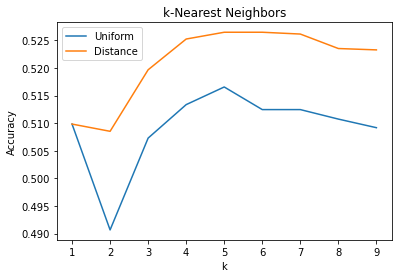

In [58]:
# First of all, we will look at the results of the kNN model.
# As we increase the k parameter, first the accuracy drops a bit, then it
# goes up again until it reaches a plateau, and finally it slightly decreases.
# Our best k parameter is 6 with 'distance' as weights parameter.
cv_result = grid_cv_results[0]
plt.plot(models_extra[0]['parameters']['n_neighbors'], cv_result['mean_test_score'][::2], label='Uniform')
plt.plot(models_extra[0]['parameters']['n_neighbors'], cv_result['mean_test_score'][1::2], label='Distance')
plt.title('k-Nearest Neighbors')
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

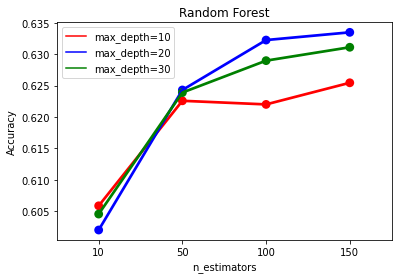

In [57]:
# Secondly, we will look at the random forest model.
# We can see that increasing the amount of estimators is helping us
# get higher accuracies. Interestingly, the middle of max_depth=20
# gives higher accuracies than as with 10 or 30 as value.
# The best parameter is max_depth=20 and n_estimators=150.
cv_result = grid_cv_results[1]
sns.pointplot(x=models_extra[1]['parameters']['n_estimators'], y=cv_result['mean_test_score'][:4],
              label='max_depth=10', color='red')
sns.pointplot(x=models_extra[1]['parameters']['n_estimators'], y=cv_result['mean_test_score'][4:8],
              label='max_depth=20', color='blue')
sns.pointplot(x=models_extra[1]['parameters']['n_estimators'], y=cv_result['mean_test_score'][8:],
              label='max_depth=30', color='green')
plt.title('Random Forest')
plt.xlabel('n_estimators')
plt.ylabel('Accuracy')
custom_lines = [Line2D([0],[0],color='red'), Line2D([0],[0],color='blue'), Line2D([0],[0],color='green')]
plt.legend(custom_lines,['max_depth=10', 'max_depth=20', 'max_depth=30'])
plt.show()

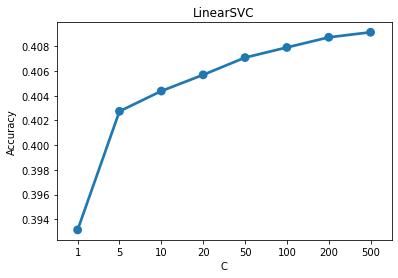

In [59]:
# Third and finally, the linear SVC model.
# Increasing the amount of C helps us get slightly higher accuracies.
# The best parameter is C=500.
cv_result = grid_cv_results[2]
sns.pointplot(x=models_extra[2]['parameters']['C'], y=cv_result['mean_test_score'])
plt.title('LinearSVC')
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.show()

<p>We tried to predict the platform label of videogame entries based on their information and sales data. We first processed the data and then tried logistic regression and multinomial naive bayes. The results could be much higher, therefore we tried other methods in order to improve the accuracies. We tried feature selection, however, the accuracy scores didn't improve at all, therefore I decided to not use feature selection. Finally, we tried three different classification models to see if that would improve the score. Indeed, we got two models that surpassed our previous best model which was logistic regression. Below we can see the accuracies of all models with their best parameters that we got from hyperparameter tuning.</p>

<table>
  <tr><th>Model Name</th><th>Best Accuracy</th><th>Micro F1-Score</th><th>Best Parameters</th></tr>
  <tr><td>RandomForestClassifier</td><td>0.63348</td><td>0.63200</td><td>max_depth=20, n_estimators=150</td></tr>
  <tr><td>KNeighborsClassifier</td><td>0.52646</td><td>0.54670</td><td>n_neighbors=6, weights='distance'</td></tr>
  <tr><td>LogisticRegression</td><td>0.48410</td><td>0.48303</td><td>C=50</td></tr>
  <tr><td>LinearSVC</td><td>0.40912</td><td>0.41519</td><td>C=500</td></tr>
  <tr><td>MultinomialNB</td><td>0.22713</td><td>0.22713</td><td>alpha=1.0</td></tr>
</table>

<p><b>The best result we got is 0.63 with the random forest classifier.</b> Judging by the plot of the random forest classifier, increasing the amount of estimators could give us better results. However, after some point overfitting could happen, that's why to keep increasing the n_estimators parameter might not be a good idea.</p>

<p>Random forest gave us the best score because it can handle large datasets very well and is also good at utilizing the features for our prediction task.</p>

<p>Overall, our goal of trying to predict the platform of a videogame using only basic information and sales data was going to be difficult from the beginning, as the information we have is not sufficient in order to make highly accurate predictions. There is probably not a way in order to predict the platform of a game better, as there is possibly no information that could help us in this case. Even if we had used the title or text description of the games, that wouldn't have helped us either, as there is no connection between the keywords of a game and it's platform. Rather, features like the release year and the publisher helped us the most for the predictions. Also, the ratio of regional sales probably had a little effect too.</p>

<p>To conclude, an accuracy of 0.63 might be a bit low, however, considering how difficult the task was, it was to be expected. Still, <b>I think getting such a score for even this difficult task is enough</b>. Perhaps we could get a little higher score using more complex, or maybe different models.</p>